In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#unpack our learning dataset
words = open('names.txt','r').read().splitlines()
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [10]:
#Vocabulary of characters an mappings from/to integers

chars = sorted(list(set(''.join(words)))) # concatenate all dataset as a sinle string and passes it thru the set constructor

stoi = {s:i+1 for i,s in enumerate(chars)} # stoi maps a-0, b-1 and so on til z-25

# what about ourspecial char
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Initialization

In [11]:
# building the dataset

block_size = 3 # context length: how many char do we take to predict the next one


def build_dataset(words):
    
    X, Y = [], [] #X are input to the NN and Y are the label for each example inside X
    for w in words[:]: #rn first 5 for efficeincy
      #print(w) 
      context = [0] * block_size # padded context of 0 tokens
      for ch in w + '.':
        ix = stoi[ch]     
        X.append(context) # stores the current running context context 
        Y.append(ix) # array y of the current character 
        context = context[1:] + [ix] # crop the context and append new char in sequence

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% of the words
Xdev, Ydev = build_dataset(words[n1:n2])# 90 -80% of the words
Xte, Yte = build_dataset(words[n2:])# remaining words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP

In [12]:
(5/3) / (n_embd * block_size)**0.5

0.3042903097250923

In [13]:
# lets get rid of all the hard coded numbers. we want to be able to play with this code
n_embd = 10# dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer



g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5   #* 0.2 # kaiming innit for gaussian check the documentation for details
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# make a single list of the parameters
param = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in param)) #number of total parameters stays same


#they all require gradients
for p in param:
  p.requires_grad = True

11897


tensor(-0.0004) <built-in method std of Tensor object at 0x7ff66901ee30>
tensor(0.0060) tensor(3.1612)


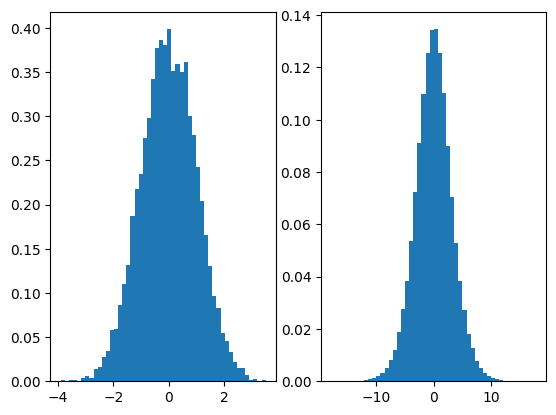

In [14]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w 
print(x.mean(), x.std)
print(y.mean(), y.std())
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50 , density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50 , density = True);

# Optimization

In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in param:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else(0.01 if i < 150000 else 0.001) # step learning rate decay
  for p in param:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  



      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7971
 170000/ 200000: 1.7410
 180000/ 200000: 1.9590
 190000/ 200000: 1.8679


In [16]:
#plt.figure(figsize = (20,10))
#plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation ='nearest')

In [17]:
#plt.hist(h.view(-1).tolist(), 50)

In [18]:
#plt.hist(hpreact.view(-1).tolist(), 50)

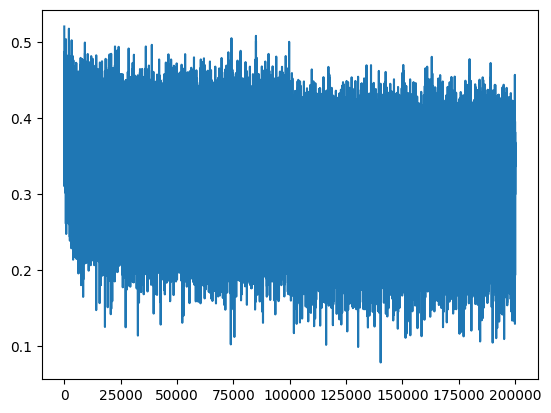

In [19]:
plt.plot(lossi)

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.136169910430908
val 2.196577310562134


# Sample 

In [21]:
g = torch.Generator().manual_seed(2147483647 + 10)


for i in range(30):
  out = []
  context = [0] * block_size
  while True:
    
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]

    out.append(ix)
    #print(itos[ix])
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

montaymyah.
see.
madhayla.
ren.
ruthndraeg.
adee.
daelin.
shi.
jen.
eden.
estina.
selyzion.
kalin.
shuberlyn.
miel.
kindreelynn.
noella.
ubakard.
ryyah.
fael.
yuve.
mysen.
daihil.
salynn.
una.
alel.
juren.
cre.
kiveaostephadir.
kyloe.


# time for batch normalization (yaay. no more worries for initialization)

In [22]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [23]:
# lets get rid of all the hard coded numbers. we want to be able to play with this code
n_embd = 10# dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer



g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5   #* 0.2 # kaiming innit for gaussian check the documentation for details
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

#batch norm gain and bias ( we want our normalised hpreact to br multiplied by some gain and have a bias added to allow the scale and shift to take place)
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_run = torch.zeros((1, n_hidden)) # running mean 
bnstd_run = torch.ones((1, n_hidden))
# make a single list of the parameters
param = [C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in param)) #number of total parameters stays same


#they all require gradients
for p in param:
  p.requires_grad = True

12297


In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
epsil = 5*10**(-6)
for i in range(max_steps):
  
  # minibatch construct
  #----------------------------------------
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  #----------------------------------------------


  # forward pass
  #------------------------------------------------------
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  #---------------------------------------------------

  #linear layer
  #----------------------------------
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation # it is customary to take these linear layers and append a batch normalizations after it to control the scale of the activation throughout the neural net. 
  # normalising hpreact to be a normal distribution
  # we only want these to be gaussian at initialization the dist should still move around (make some nuerons more trigger happy)
  #-------------------------------------
  
  #batch norm layer
  # note : we got rid of b1 cause the batchnorm will subtract the bias from hpreact and add its own bias
  #NOTE: this layer can cause a huge amout of bugs as it couples examples in the forward pass
  #------------------------------------
  bnmeani = hpreact.mean(0, keepdim = True)
  bnstdi = hpreact.std(0, keepdim = True)
  hpreact = bnbias + (bngain * (hpreact - bnmeani) /(bnstdi + epsil)) # standardising the activations but we also need scale and shift ( lets our backpropagation define how this didst moves around)
  # adding epsil to prevent any division by zero (this NN is quite small so it wont happen but always good to have it just in case)
  # now every single neuron and its firing rate will be EXACTLY unit gaussian on the 32 examples of our batch (we are normalising batches hence BATCH NORM)
  with torch.no_grad():
    bnmean_run = 0.999 * bnmean_run + 0.001 * bnmeani
    bnstd_run = 0.999 * bnstd_run + 0.001 * bnstdi
 #------------------------------------------------------

  #NON-linearity
  #--------------------------------------------------
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  #--------------------------------------------

  #IMPORTANT NOTE: when making deep neural networks you wiil stack up the weight layer(linear layer), batch normalization layer and nonlinearity. this is the motif you want when making bigger neural networks

  # backward pass
  #----------------------------------------------
  for p in param:
    p.grad = None
  loss.backward()
  #-----------------------------------------------


  # update
  #---------------------------------------------------
  lr = 0.1 if i < 100000 else(0.01 if i < 150000 else 0.001) # step learning rate decay
  for p in param:
    if p.grad is not None:
      p.data += -lr * p.grad
  #---------------------------------------------------

  # track stats
  #-------------------------------------------------------
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #----------------------------------------------------------
  


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.1051
 170000/ 200000: 2.4556
 180000/ 200000: 2.0183
 190000/ 200000: 2.1738


In [36]:
# calibrate the batch norm at the end of training
# lets us forward a single example
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  #+ b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [37]:
#bnmean

In [38]:
#bnmean_run

In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  #+ b1
  #hpreact = bnbias + (bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True))
  hpreact = bnbias + ((bngain * (hpreact - bnmean)) / bnstd)
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.336772918701172
val 2.341789960861206


# Lets Summarize and make everything clean

In [106]:
# Lets creater a deeper network

# create a linear layer (like the hpreact but more suited for pytorch)
#-------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias =True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
#-------------------------------------------------------------------------------

#Batch Normalization Layer
#-------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # for when we train the nueral net
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update') (not part of the back propagation)
    self.running_mean = torch.zeros(dim) # for inference
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): #use this because if you dont then pytorch will star building out an entire computational graph cause it will expect that eventually we will back propagate thru this (call .backward)
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean #exponential moving average
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
#-------------------------------------------------------------------------------

#Non-Linearity
#-------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
#-------------------------------------------------------------------------------

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers with batch norm (ususally between linear layer and non linearity but we can try to paly around to suit some specific purposes)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layer without batch norm
#layers = [
#  Linear(n_embd * block_size, n_hidden), Tanh(),
 # Linear(           n_hidden, n_hidden), Tanh(),
  #Linear(           n_hidden, n_hidden), Tanh(),
  #Linear(           n_hidden, n_hidden), Tanh(),
 # Linear(           n_hidden, n_hidden), Tanh(),
  #Linear(           n_hidden, vocab_size),
#]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1 # for batchnorm
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0 

parameters = [C] + [p for layer in layers for p in layer.parameters()] # embedding matrix
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [113]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else(0.01 if i < 150000 else 0.001) # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # keeping track of the update to data ratio (update is lr * grad)

  #if i >= 1000:
   #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.6653
  10000/ 200000: 2.1177
  20000/ 200000: 2.2528
  30000/ 200000: 1.8875
  40000/ 200000: 2.1577
  50000/ 200000: 2.0096
  60000/ 200000: 1.7083
  70000/ 200000: 1.8976
  80000/ 200000: 2.2429
  90000/ 200000: 1.8039
 100000/ 200000: 1.7697
 110000/ 200000: 1.8217
 120000/ 200000: 1.6163
 130000/ 200000: 1.7348
 140000/ 200000: 1.8547
 150000/ 200000: 2.0611
 160000/ 200000: 2.0733
 170000/ 200000: 2.0114
 180000/ 200000: 1.8044
 190000/ 200000: 1.7008


layer 2 (      Tanh): mean +0.03, std 0.80, saturated: 30.53%
layer 5 (      Tanh): mean -0.02, std 0.88, saturated: 52.16%
layer 8 (      Tanh): mean -0.01, std 0.90, saturated: 52.22%
layer 11 (      Tanh): mean +0.03, std 0.90, saturated: 54.31%
layer 14 (      Tanh): mean +0.01, std 0.92, saturated: 60.22%


Text(0.5, 1.0, 'activation distribution')

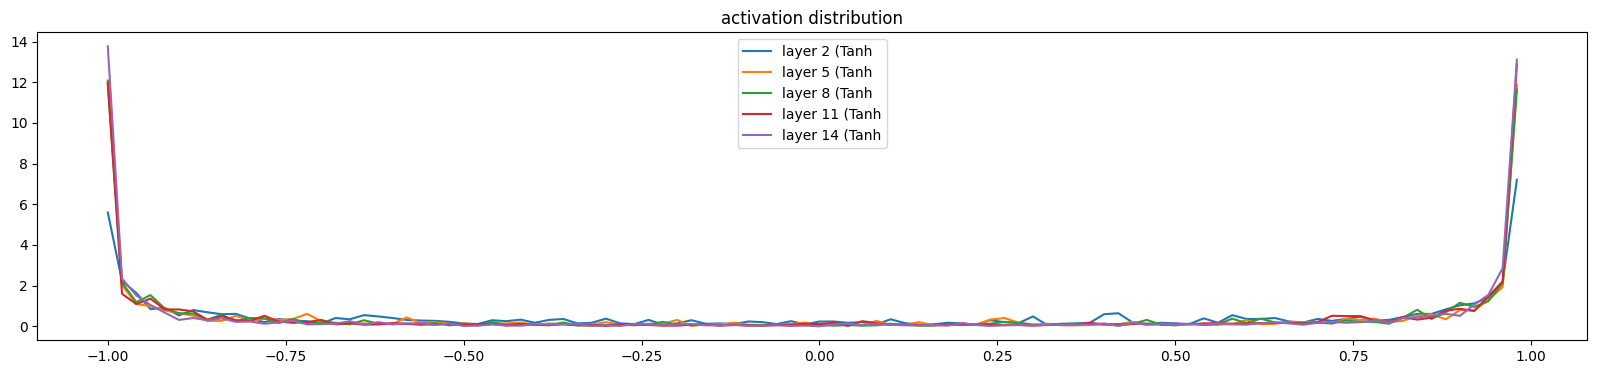

In [114]:
# visualize histograms for the FORWARD PASS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000119, std 3.646601e-03
layer 5 (      Tanh): mean -0.000031, std 3.187076e-03
layer 8 (      Tanh): mean +0.000016, std 2.949693e-03
layer 11 (      Tanh): mean -0.000014, std 3.186323e-03
layer 14 (      Tanh): mean -0.000040, std 4.711509e-03


Text(0.5, 1.0, 'gradient distribution')

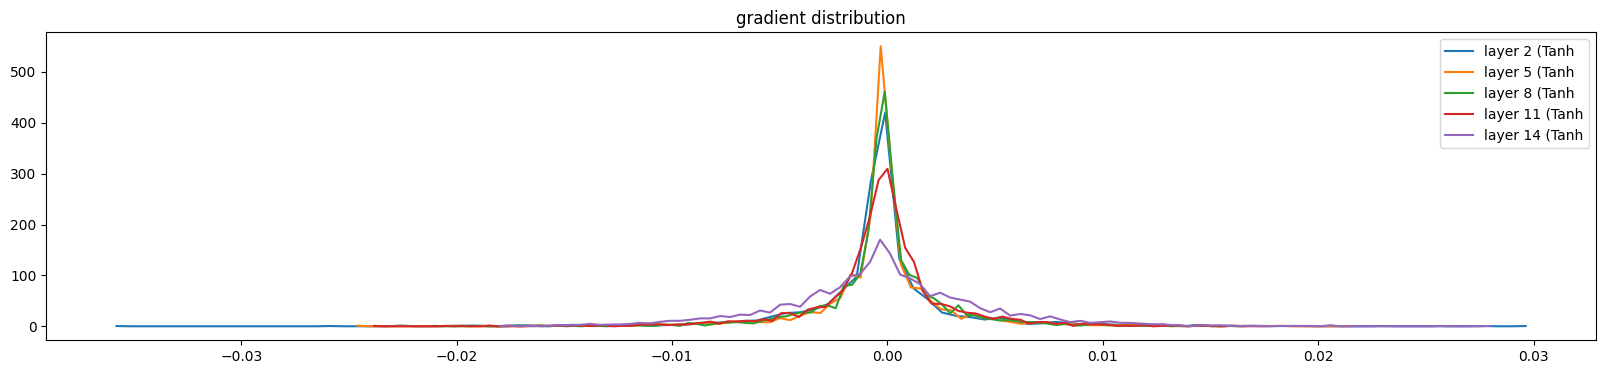

In [115]:
# visualize histograms for the GRADIENTS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.001603 | std 1.406725e-02 | grad:data ratio 1.182214e-02
weight  (30, 100) | mean +0.000130 | std 8.499520e-03 | grad:data ratio 1.869117e-02
weight (100, 100) | mean +0.000015 | std 5.570151e-03 | grad:data ratio 2.065491e-02
weight (100, 100) | mean +0.000006 | std 5.431059e-03 | grad:data ratio 2.054449e-02
weight (100, 100) | mean -0.000001 | std 5.309932e-03 | grad:data ratio 2.059838e-02
weight (100, 100) | mean +0.000059 | std 5.485105e-03 | grad:data ratio 2.170283e-02
weight  (100, 27) | mean +0.000003 | std 1.412839e-02 | grad:data ratio 4.333246e-02


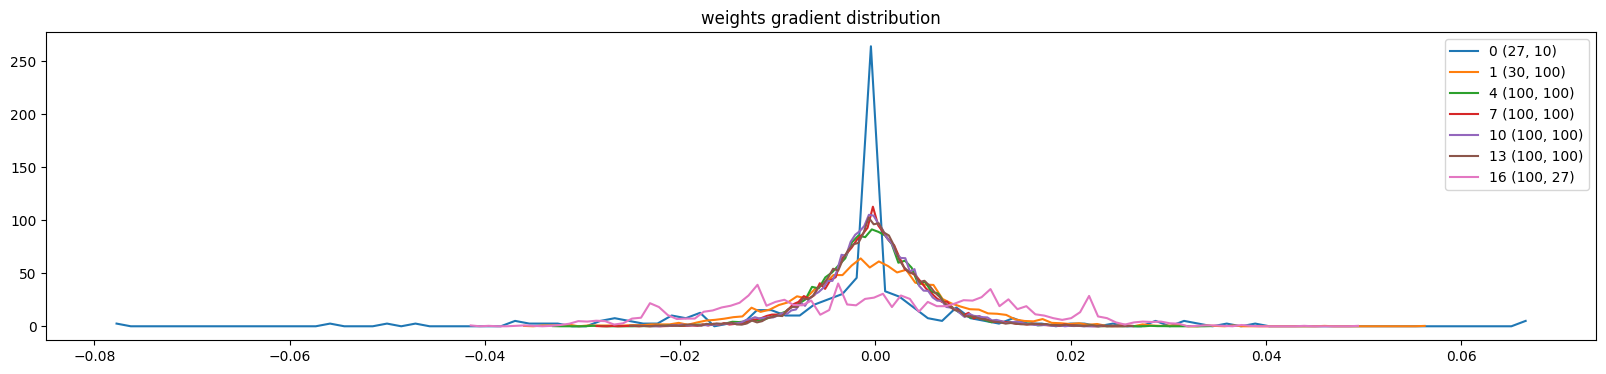

In [116]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: #constraining to just weights
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

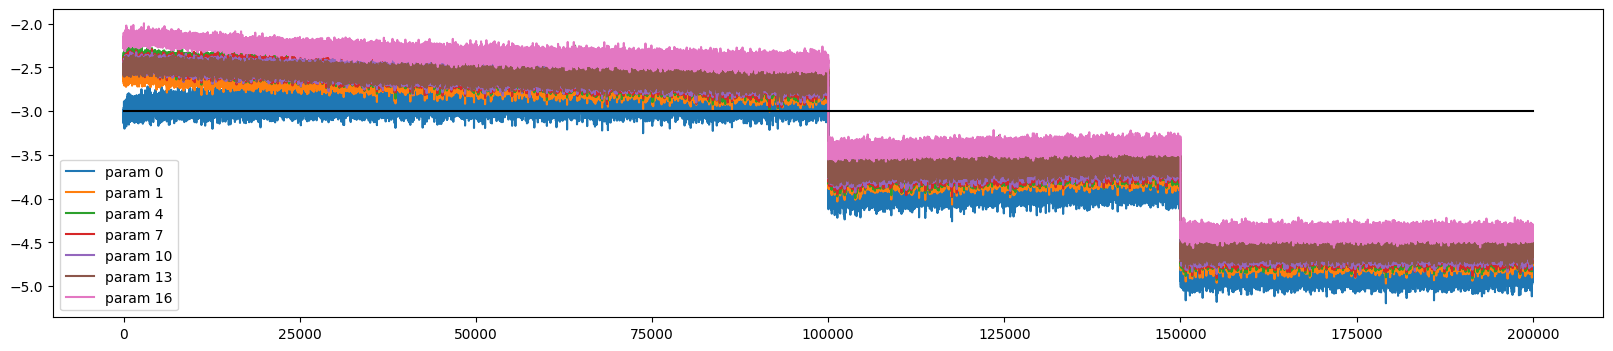

In [117]:
#Update to data ratio 

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# note the final layer here (pink) is an outlier because it was artificially shrunk down to keep the softmax unconfident

In [118]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9648361206054688
val 2.07930850982666


In [119]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhanalee.
than.
endraegan.
ched.
elin.
shyloni.
eden.
est.
nar.
kayziellara.
noshubergiagrael.
kin.
renleigh.
terifford.
geda.
jamelizeki.
kayshayan.
daihia.


# extra content play around!

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

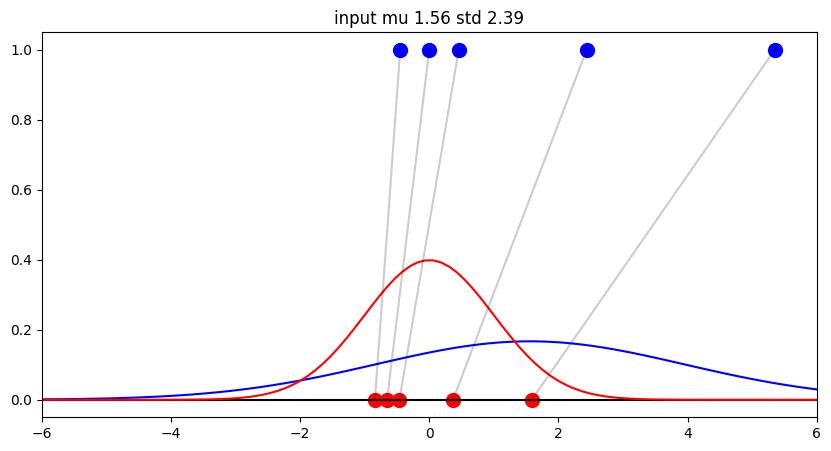

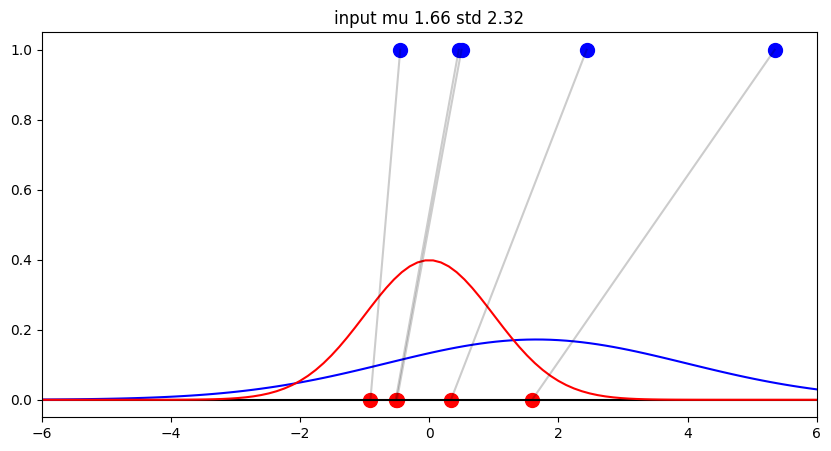

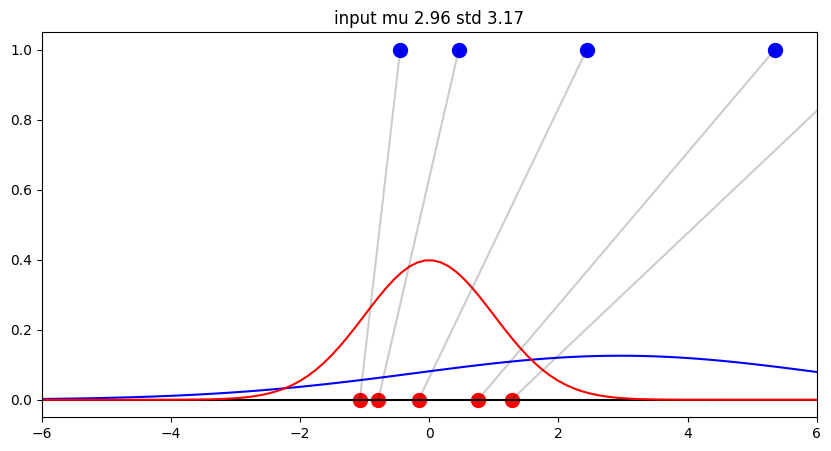

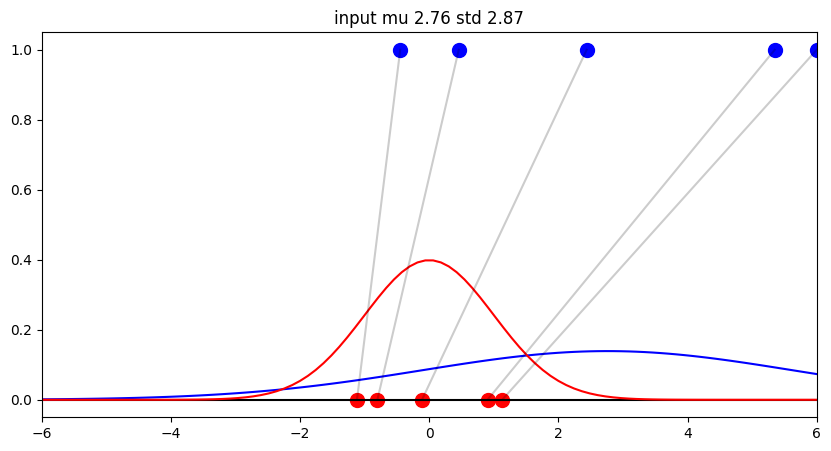

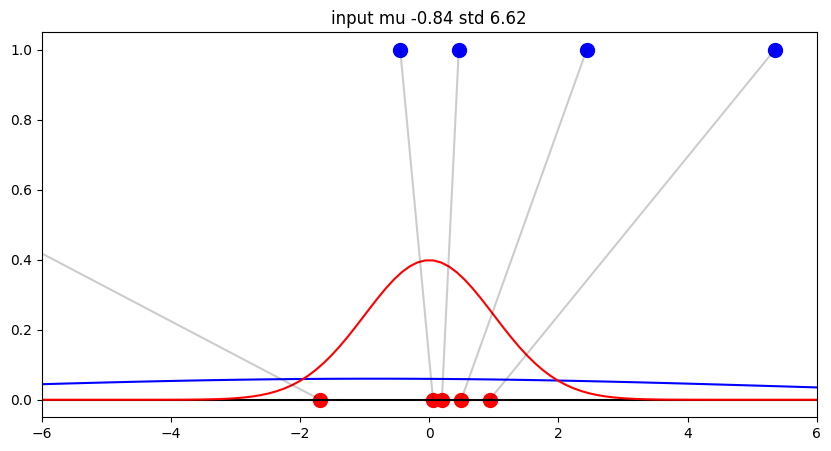

In [120]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [121]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [122]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
